In [1]:
import os
os.environ['NUMPY_EXPERIMENTAL_ARRAY_FUNCTION'] = '0'

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs # A pythonic file-system interface to Google Cloud Storage
from tqdm.autonotebook import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [2]:
import math
import copy
from scipy.interpolate import griddata
import seawater as sw
from mpl_toolkits.basemap import Basemap, cm, maskoceans

In [3]:
# Cluster was created via the dask labextension
# Delete this cell and replace with a new one

from dask.distributed import Client
from dask_kubernetes import KubeCluster

cluster = KubeCluster()
cluster.adapt(minimum=1, maximum=20, interval='2s')
client = Client(cluster)
client

distributed.scheduler - INFO - Clear task state
/srv/conda/envs/notebook/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
distributed.scheduler - INFO -   Scheduler at:    tcp://10.32.2.26:43573
distributed.scheduler - INFO -   dashboard at:                    :33077
distributed.scheduler - INFO - Receive client connection: Client-b83d3a62-4d15-11ea-8431-c2fa316413c6
distributed.core - INFO - Starting established connection


Client Scheduler: tcp://10.32.2.26:43573 Dashboard: /user/0000-0002-3606-2575/proxy/33077/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [4]:
import warnings; warnings.simplefilter('ignore')

In [58]:
def func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, lat_min_regrid, lat_max_regrid, lon_min_regrid, lon_max_regrid): 
    #### Latitude Bounds ####
    Lat_regrid_1D= np.zeros ((lat_n_regrid+1));
    Lat_bound_regrid = np.zeros ((lat_n_regrid+1,2)); Lat_bound_regrid[0,0]=-90;  Lat_bound_regrid[0,1]=Lat_bound_regrid[0,0] + ( (180/lat_n_regrid) /2 ); Lat_regrid_1D[0]=(Lat_bound_regrid[0,0]+Lat_bound_regrid[0,1])/2
    for ii in range(1,lat_n_regrid+1):
        Lat_bound_regrid[ii,0]=Lat_bound_regrid[ii-1,1]
        Lat_bound_regrid[ii,1]=Lat_bound_regrid[ii,0] +  (180/lat_n_regrid)
        Lat_regrid_1D[ii]=(Lat_bound_regrid[ii,0]+Lat_bound_regrid[ii,1])/2
    Lat_bound_regrid[-1,1]=90;  Lat_regrid_1D[-1]=(Lat_bound_regrid[-1,0]+Lat_bound_regrid[-1,1])/2
    #### Longitude Bounds ####
    Lon_regrid_1D= np.zeros ((lon_n_regrid));
    Lon_bound_regrid = np.zeros ((lon_n_regrid,2)); Lon_bound_regrid[0,0]=0;  Lon_bound_regrid[0,1]=Lon_bound_regrid[0,0] + (360/lon_n_regrid); Lon_regrid_1D[0]=(Lon_bound_regrid[0,0]+Lon_bound_regrid[0,1])/2
    for ii in range(1,lon_n_regrid):
        Lon_bound_regrid[ii,0]=Lon_bound_regrid[ii-1,1]
        Lon_bound_regrid[ii,1]=Lon_bound_regrid[ii,0] +  (360/lon_n_regrid)
        Lon_regrid_1D[ii]=(Lon_bound_regrid[ii,0]+Lon_bound_regrid[ii,1])/2
    
    return Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid


def func_regrid(Data_orig, Lat_orig, Lon_orig, Lat_regrid_2D, Lon_regrid_2D):    
    
    Lon_orig[Lon_orig < 0] +=360
    if np.ndim(Lon_orig)==1: # If the GCM grid is not curvlinear
        Lon_orig,Lat_orig=np.meshgrid(Lon_orig, Lat_orig)
        
    lon_vec = np.asarray(Lon_orig)
    lat_vec = np.asarray(Lat_orig)
    lon_vec = lon_vec.flatten()
    lat_vec = lat_vec.flatten()
    coords=np.squeeze(np.dstack((lon_vec,lat_vec)))

    Data_orig=np.squeeze(Data_orig)
    if Data_orig.ndim==2:#this is for 2d regridding
        data_vec = np.asarray(Data_orig)
        if np.ndim(data_vec)>1:
            data_vec = data_vec.flatten()
        Data_regrid = griddata(coords, data_vec, (Lon_regrid_2D, Lat_regrid_2D), method='nearest')
        return np.asarray(Data_regrid)
    if Data_orig.ndim==3:#this is for 3d regridding
        Data_regrid=[]
        for d in range(len(Data_orig)):
            z = np.asarray(Data_orig[d,:,:])
            if np.ndim(z)>1:
                z = z.flatten()
            zi = griddata(coords, z, (Lon_regrid_2D, Lat_regrid_2D), method='nearest')
            Data_regrid.append(zi)
        return np.asarray(Data_regrid)
    
#### running mean calculation ####
def runningMeanFast(x, N):
    return np.convolve(x, np.ones((N,))/N)[(N-1):]

#### Compute and plot lagged regression plot####
def lag_cor(x,y,lag, c, l):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    x=np.linspace(-lag,lag+1, 2*lag)
    plt.grid(True,which="both",ls="-", color='0.65')
    plt.plot(x, stat, c, label=l, linewidth=3.0)
    plt.xlabel('Year lag')
    plt.ylabel('r')
    
def lag_cor_data(x,y,lag):
    stat=[]
    from scipy import stats
    for i in range(2*lag):
        slope, intercept, r_value, p_value, std_err = stats.linregress(x[lag:len(x)-lag], y[i:len(y)-2*lag+i])
        stat.append(r_value)
    return stat

## Regridding calculations
creating new coordinate grid, same which was used in interpolation in data processing code

In [6]:
lat_n_regrid, lon_n_regrid = 180, 360 # Number of Lat and Lon elements in the regridded data
lon_min_regrid, lon_max_regrid = 0, 360 # Min and Max value of Lon in the regridded data
lat_min_regrid, lat_max_regrid = -90, 90 # Min and Max value of Lat in the regridded data

Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, lat_min_regrid, lat_max_regrid, lon_min_regrid, lon_max_regrid)
Lon_regrid_2D, Lat_regrid_2D = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)

In [7]:
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [8]:
def func_load_ds_uri(uri):
    """
    Load data for given uri
    """
    gcs = gcsfs.GCSFileSystem(token='anon') # GCSFS will attempt to use your default gcloud credentials
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [9]:
GCM_name = 'GFDL-CM4'

In [10]:
df_plt = df[(df.table_id == 'Omon') & (df.variable_id == 'thetao') & (df.activity_id == 'CMIP') & (df.experiment_id == 'piControl')& (df.source_id==GCM_name)]
df_plt = df_plt[ df_plt['grid_label'] == 'gr']
#run_counts = df_plt.groupby(['source_id', 'experiment_id'])['zstore'].count()
#run_counts
uri_thetao = df_plt[(df_plt.source_id == GCM_name)].zstore.values[0]
uri_thetao

'gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/thetao/gr/'

In [11]:
df_plt = df[(df.table_id == 'Omon') & (df.variable_id == 'so') & (df.activity_id == 'CMIP') & (df.experiment_id == 'piControl')& (df.source_id==GCM_name)]
df_plt = df_plt[ df_plt['grid_label'] == 'gr']
uri_so = df_plt[(df_plt.source_id == GCM_name)].zstore.values[0]
uri_so

'gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/so/gr/'

In [12]:
ds_thetao = func_load_ds_uri(uri_thetao)
ds_so = func_load_ds_uri(uri_so)

distributed.scheduler - INFO - Register tcp://10.32.21.8:37569
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.21.8:37569
distributed.core - INFO - Starting established connection


In [ ]:
ds_thetao

In [ ]:
#aa = ds_thetao.sel(time=slice('0151-01-16 12:00:00', '0650-12-16 12:00:00'))

In [ ]:
ds_thetao.time

In [ ]:
ds_thetao.time.values

In [ ]:
ds_thetao.time.dt.year.values

In [ ]:
ds_thetao.time.dt.year.to_index()

In [ ]:
#da2 = ds_thetao[ (ds_thetao.time.dt.year.values>=152) & (ds_thetao.time.dt.year.values<=649)]

In [ ]:
#ds_thetao = ds_thetao.isel(time=slice(0,500*12))
#ds_so = ds_so.isel(time=slice(0,500*12))

In [13]:
GCM = GCM_name
year_start=1
year_end=500

conv_index_depth_ws=500 # args[7] in func_time_depth_plot code - depth for Convection Index
conv_index_depth_lab=500

### LAB_index and WS_index are the convection indeces at 500m depth ###
#### Weddel Sea Caclulations ####
month_no=9 # args[2] in main code # month of the year
hemis_no=0 # args[3] in main code # 0 means NH / 1 means SH

In [14]:
ds_thetao = ds_thetao.isel(time=slice(year_start-1, year_end*12))
ds_so = ds_so.isel(time=slice(year_start-1, year_end*12))

In [15]:
Depths=ds_thetao.lev.values
Depths.shape

(35,)

Conv_area_timeseries_WS, MLD_years_WS, lon_mld_WS, lat_mld_WS, WS_indeces_lonlat = func_MLD(dset_thetao, dset_so, month_ws, hemis_ws, year_start, year_end, CellArea, 90, 180)
MLD_average_WS=np.nanmean(MLD_years_WS,axis=0)

In [16]:
def func_MLD(dset_thetao, dset_so, month_no, hemis_no):
    import seawater as sw
    
    yrs_no = np.int(len(ds_thetao.time)/12)
    Depths=ds_thetao.lev.values

    if hemis_no==0:
        depth_MLD_tr=1000 # Weddell Sea - [30E-60W]
    elif hemis_no==1:
        depth_MLD_tr=1000 # Labrador Sea  - [60W-30W]
    elif hemis_no==2:
        depth_MLD_tr=2000 # Norwegian Sea
    elif hemis_no==3:
        depth_MLD_tr=1000 # Labrador Sea  - [60W-40W]   
    else:
        depth_MLD_tr=2000
    deep_conv_area=[]
    
    Lon_orig=ds_thetao.lon.values
    Lat_orig=ds_thetao.lat.values 
    if np.ndim(Lon_orig)==1: # If the GCM grid is not curvlinear
        Lon_orig,Lat_orig=np.meshgrid(Lon_orig, Lat_orig)    
        
    lat_n=Lat_orig.shape[0] # Number of Lat elements in the data
    lon_n=Lon_orig.shape[1] # Number of Lon elements in the data
    earth_R = 6378e3 # Earth Radius - Unit is kilometer (km)
    GridCell_Areas = np.zeros ((lat_n, lon_n )) # A = 2*pi*R^2 |sin(lat1)-sin(lat2)| |lon1-lon2|/360 = (pi/180)R^2 |lon1-lon2| |sin(lat1)-sin(lat2)| 
    for ii in range(1,lat_n-1):
        for jj in range(1,lon_n-1):
            GridCell_Areas [ii,jj] = math.fabs( (earth_R**2) * (math.pi/180) * np.absolute( (Lon_orig[ii,jj-1]+Lon_orig[ii,jj])/2  -  (Lon_orig[ii,jj]+Lon_orig[ii,jj+1])/2 )  * np.absolute( math.sin(math.radians( ( Lat_orig[ii-1,jj]+Lat_orig[ii,jj])/2 )) - math.sin(math.radians( Lat_orig[ii,jj]+Lat_orig[ii+1,jj])/2  )) )                  
    for ii in range(1,lat_n-1):
        for jj in range(2,lon_n-2):
            if GridCell_Areas [ii,jj] > GridCell_Areas [ii,jj-1]*3:
                GridCell_Areas [ii,jj]=GridCell_Areas [ii,jj-1]
            if GridCell_Areas [ii,jj] > GridCell_Areas [ii,jj+1]*3:
                GridCell_Areas [ii,jj]=GridCell_Areas [ii,jj+1]
    GridCell_Areas[0,:]=GridCell_Areas[1,:]; GridCell_Areas[-1,:]=GridCell_Areas[-2,:]
    GridCell_Areas[:,0]=GridCell_Areas[:,1]; GridCell_Areas[:,-1]=GridCell_Areas[:,-2]
    areacello=GridCell_Areas      
    
    lat_n_regrid=90
    lon_n_regrid=180
    Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, -90, 90, 0, 360)
    lon, lat = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)
    areacello = func_regrid(areacello, Lat_orig, Lon_orig, lat, lon)
    
    # ds_so.so.isel(lev=slice(0,10))   # slice(start, end, step)
    
    data_plot=np.full([yrs_no,len(lon),len(lon[0])], np.nan)    
    
    for t in tqdm(range(yrs_no)):
        #print('MLD calc - Year: ', t+1)
        data_thetao_extracted = ds_thetao.thetao.isel(time= 12*t+month_no-1 ).values
        data_so_extracted = ds_so.so.isel(time= 12*t+month_no-1 ).values
        data_dens=sw.dens0(data_so_extracted, data_thetao_extracted-273.15)
        depth10m_shalow=0
        depth10m_deep=0
        depth_array=np.asarray(Depths)
        
        for k in range(len(Depths)):
            if Depths[k]<=10:
                depth10m_shalow=k
        for k in range(len(Depths)):        
            if Depths[k]>=10:
                depth10m_deep+=k
                break
                
        interpol_x = [Depths[depth10m_shalow], Depths[depth10m_deep]]
        data_i=data_dens
        data_i = func_regrid(data_dens, Lat_orig, Lon_orig, lat, lon)
        data_i[data_i>100000]=np.nan
        
        if (int(hemis_no)==int(0)):# Weddell Sea
            [ii,jj] = np.where(lat<=-50)###indeces####
        elif (int(hemis_no)==int(1)):# Labrador Sea  - [60W-30W]
            [ii,jj] = np.where(lat>=50)###indeces####
        elif (int(hemis_no)==int(2)):# Norwegian Sea
            [ii,jj] = np.where(lat>=58)###indeces####
        elif (int(hemis_no)==int(3)):# Labrador Sea  - [60W-40W]  
            [ii,jj] = np.where(lat>=50)###indeces####            
        else:
            print(hemis_no)
            print('invalid input for hemisphere option')
            break                

        area=0
        for k in range(len(ii)):
            if not(str(data_i[0,ii[k],jj[k]])=='nan'):
                dummy=100
                interpol_dens = [data_i[depth10m_shalow,ii[k],jj[k]], data_i[depth10m_deep,ii[k],jj[k]]]
                p_10m_dens = np.interp(10, interpol_x, interpol_dens)
                for d in range(len(data_i)):
                    if not(str(data_i[0,ii[k],jj[k]])=='nan'):
                        p_dens = data_i[d,ii[k],jj[k]]
                        if abs(p_dens-p_10m_dens-0.03)<dummy:
                            dummy=abs(p_dens-p_10m_dens-0.03)
                            MLD=d
                if MLD==0:
                    MLD+=1
                    p_dens_interpol = [data_i[MLD-1,ii[k],jj[k]]-p_10m_dens,data_i[MLD,ii[k],jj[k]]-p_10m_dens,data_i[MLD+1,ii[k],jj[k]]-p_10m_dens]
                    depth_levels = [depth_array[MLD-1],depth_array[MLD],depth_array[MLD+1]]
                ##elif MLD==49:
                elif MLD==len(data_i)-1: # If MLD is the last layer                   
                    MLD-=1
                    p_dens_interpol = [data_i[MLD-1,ii[k],jj[k]]-p_10m_dens,data_i[MLD,ii[k],jj[k]]-p_10m_dens,data_i[MLD+1,ii[k],jj[k]]-p_10m_dens]
                    depth_levels = [depth_array[MLD-1],depth_array[MLD],depth_array[MLD+1]]
                else:
                    p_dens_interpol = [data_i[MLD-1,ii[k],jj[k]]-p_10m_dens,data_i[MLD,ii[k],jj[k]]-p_10m_dens,data_i[MLD+1,ii[k],jj[k]]-p_10m_dens]
                    depth_levels = [depth_array[MLD-1],depth_array[MLD],depth_array[MLD+1]]
                interpol_z=np.interp(0.03,p_dens_interpol,depth_levels)
                if interpol_z>=depth_MLD_tr:
                #y1+=float(interpol_z)
                    area+=areacello[ii[k],jj[k]]
                    data_plot[t,ii[k],jj[k]]=float(interpol_z)     
        deep_conv_area.append(area)
    deep_conv_area=np.asarray(deep_conv_area)   
    
    average_MLD=np.nanmean(data_plot,axis=0)
    if hemis_no==0: # SH, Weddell Sea
        indeces = np.where(np.logical_or((lon<=30) & (average_MLD>depth_MLD_tr), (lon>=300) &(average_MLD>depth_MLD_tr)))
    elif hemis_no==1: # NH, Labrador Sea  - [60W-30W]
        indeces = np.where(np.logical_and((lon>=30) & (average_MLD>depth_MLD_tr), (lon<=330) &(average_MLD>depth_MLD_tr)))
    elif hemis_no==2: # NH, Norwegian Sea
        indeces = np.where(np.logical_or((lon<=30) & (average_MLD>depth_MLD_tr), (lon>=345) &(average_MLD>depth_MLD_tr)))
    elif hemis_no==3: # NH, Labrador Sea  - [60W-40W]
        indeces = np.where(np.logical_and((lon>=30) & (average_MLD>depth_MLD_tr), (lon<=320) &(average_MLD>depth_MLD_tr)))
    else: ### This should never be the case though ###
        indeces = np.where(np.logical_and((lon>=30) & (average_MLD>depth_MLD_tr), (lon<=330) &(average_MLD>depth_MLD_tr)))        
        
    return deep_conv_area, data_plot, lon, lat, indeces     
    

In [17]:
conv_index_depth = 500

In [18]:
def func_time_depth_plot(dset_thetao, indeces, conv_index_depth):

    Depths=ds_thetao.lev.values
    yrs_no = np.int(len(ds_thetao.time)/12)
    Lon_orig=ds_thetao.lon.values
    Lat_orig=ds_thetao.lat.values    
    
    [ii,jj]=indeces
    region=[]
    
    lat_n_regrid=90
    lon_n_regrid=180
    Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, -90, 90, 0, 360)
    lon, lat = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)     
    
    for t in tqdm(range(yrs_no)):
        data = ds_thetao.thetao.isel(time= slice(12*t,12*t+11) ).values
        data=np.asarray(data)
        #data[data>100000]=np.nan
        data=np.nanmean(data,axis=0)
        data=np.squeeze(data)
        data_i = func_regrid(data, Lat_orig, Lon_orig, lat, lon)
        data_i=data_i[:,ii,jj]
        
        #print('time_depth_plot calc - Year: ', t+1)
        region.append(np.nanmean(data_i,axis=1))

    depth_index_start=0
    depth_index_end=0
    if conv_index_depth==0:
        depth_index_start=0
        depth_index_end=1
    else:
        for i in range(len(Depths[:])):
            if Depths[i]<=conv_index_depth:
                depth_index_start=i
        for i in range(len(Depths[:])):
            if Depths[i]<=conv_index_depth:
                depth_index_end=i
    if depth_index_end==0:
        depth_index_end+=1        
        
        
    print(depth_index_start)
    region=np.asarray(region)
    convection_index=region[:,depth_index_start]
    return region,convection_index

In [ ]:
Conv_area_timeseries_WS, MLD_years_WS, lon_mld_WS, lat_mld_WS, WS_indeces_lonlat = func_MLD(ds_thetao, ds_so, month_no, hemis_no)
MLD_average_WS=np.nanmean(MLD_years_WS,axis=0)


In [ ]:
WS_index_time_depth, WS_index=func_time_depth_plot(ds_thetao, WS_indeces_lonlat, conv_index_depth_ws) # WS_index is the convection indeces at 500m depth
WS_index_norm=(WS_index-np.nanmean(WS_index))/np.std(WS_index) # Normalized Convection Index

WS_index_norm_rm = runningMeanFast(WS_index_norm, 10)#if data is not smoothed
WS_index_norm_rm=WS_index_norm_rm[:-9]

In [ ]:
Conv_area_timeseries_WS, MLD_years_WS, lon_mld_WS, lat_mld_WS, WS_indeces_lonlat = func_MLD(ds_thetao, ds_so, month_no, hemis_no)
MLD_average_WS=np.nanmean(MLD_years_WS,axis=0)

WS_index_time_depth, WS_index=func_time_depth_plot(ds_thetao, WS_indeces_lonlat, conv_index_depth_ws) # WS_index is the convection indeces at 500m depth
WS_index_norm=(WS_index-np.nanmean(WS_index))/np.std(WS_index) # Normalized Convection Index

WS_index_norm_rm = runningMeanFast(WS_index_norm, 10)#if data is not smoothed
WS_index_norm_rm=WS_index_norm_rm[:-9]

In [ ]:
var_list_short=['Conv_area_timeseries_WS', 'Depths', 'GCM', 'Lat_bound_regrid', 'Lat_regrid_1D', 'Lat_regrid_2D', 'Lon_bound_regrid',
       'Lon_regrid_1D', 'Lon_regrid_2D', 'MLD_average_WS', 'MLD_years_WS', 'WS_indeces_lonlat', 'WS_index',
       'WS_index_norm', 'WS_index_norm_rm', 'WS_index_time_depth', 'conv_index_depth_ws', 'lat_mld_WS', 'lon_mld_WS', 'year_end', 'year_start']
###############################################################################
###########                 Saving Results                #####################
import os
import shelve

dir_pwd = os.getcwd() # Gets the current directory (and in which the code is placed)
filename_out = (dir_pwd + '/AllResults_'+GCM+'_500yr.out') # Directory to save processed data

### To save
my_shelf = shelve.open(filename_out,'n') # 'n' for new

for key in var_list_short:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()


In [ ]:
##############################################################################
#################        To restore:        ##################################
# import os
# import shelve

# dir_pwd = os.getcwd() # Gets the current directory (and in which the code is placed)
# filename_out = (dir_pwd + '/AllResults_'+GCM+'_500yr.out') # Directory to save processed data

# my_shelf = shelve.open(filename_out)
# for key in my_shelf:
#     globals()[key]=my_shelf[key]
# my_shelf.close()

In [ ]:
##################################################
#%% Convection Index Plots - WS and LAB ###
###########################################
### Weddel Sea Plots ####

In [ ]:
fig=plt.figure()
years=np.linspace(year_start,year_end,year_end-year_start+1)
plt.plot(years, Conv_area_timeseries_WS,'b')
plt.xlabel('Years', fontsize=18)
plt.ylabel('Deep Convection Area (m2) - WS', fontsize=18)
plt.title('Deep Convection Area [m2] (Weddell Sea) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
mng = plt.get_current_fig_manager()
#mng.window.showMaximized() # Maximizes the plot window to save figures in full    
#fig.savefig(dir_figs+str(GCM)+'_deep_conv_area_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
fig=plt.figure()
if hemis_no==0:
    m = Basemap( projection='spstere',lon_0=0,boundinglat=-30)
else:
    m = Basemap( projection='npstere',lon_0=0,boundinglat=30)
#m = Basemap(projection='mill',lon_0=180)
m.drawcoastlines(linewidth=1.25)
m.fillcontinents(color='0.8')
#m.drawmapboundary(fill_color='#000099')
m.drawparallels(np.arange(-90,90,20), labels=[1,1,0,1])
m.drawmeridians(np.arange(0,360,30), labels=[1,1,0,1])
#lon[lon > 180] -= 360
im=m.contourf(lon_mld_WS,lat_mld_WS,MLD_average_WS,200,latlon=True, cmap=plt.cm.jet)
plt.colorbar(im)
m.scatter(lon_mld_WS[WS_indeces_lonlat],lat_mld_WS[WS_indeces_lonlat],2,latlon=True)
plt.title('Average MLD [m] (Weddell Sea) - '+str(year_start)+'-'+str(year_end)+' - '+m = Basemap( projection='spstere',lon_0=0,boundinglat=-30)

fig=plt.figure()
years=np.linspace(year_start,year_end,year_end-year_start+1)
im = plt.contourf(years, Depths, np.transpose(da_thetao_ws_sept_ave), 60, cmap=plt.cm.jet) # contour(X,Y,Z,N) - N shows the number of contour levels
plt.gca().invert_yaxis()
l = plt.axhline(y=500)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Depth [m]', fontsize=18)
plt.title('Temperature timeseries (C) in Weddell Sea - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
cbar = m.colorbar(im,"right", size="3%", pad="2%", extend='max') # extend='both' will extend the colorbar in both sides (upper side and down side)
cbar.set_label('(C)')
mng = plt.get_current_fig_manager()
#mng.window.showMaximized() # Maximizes the plot window to save figures in full
#fig.savefig(dir_figs+str(GCM)+'_index_time_depth_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')str(GCM), fontsize=18)
mng = plt.get_current_fig_manager()
#mng.window.showMaximized() # Maximizes the plot window to save figures in full
#fig.savefig(dir_figs+str(GCM)+'_average_MLD_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
fig=plt.figure()
years=np.linspace(year_start,year_end,year_end-year_start+1)
im = plt.contourf(years, Depths, np.transpose(WS_index_time_depth-273.15), 60, cmap=plt.cm.jet) # contour(X,Y,Z,N) - N shows the number of contour levels
plt.gca().invert_yaxis()
l = plt.axhline(y=conv_index_depth_ws)
plt.xlabel('Years', fontsize=18)
plt.ylabel('Depth [m]', fontsize=18)
plt.title('Temperature timeseries (C) in Convection Area (Weddell Sea) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
cbar = m.colorbar(im,"right", size="3%", pad="2%", extend='max') # extend='both' will extend the colorbar in both sides (upper side and down side)
cbar.set_label('(C)')
mng = plt.get_current_fig_manager()
#mng.window.showMaximized() # Maximizes the plot window to save figures in full
#fig.savefig(dir_figs+str(GCM)+'_index_time_depth_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
fig=plt.figure()
years=np.linspace(year_start,year_end,year_end-year_start+1)
im = plt.contourf(years, Depths[0:11], np.transpose(WS_index_time_depth[:,0:11]-273.15), 40, cmap=plt.cm.jet)
plt.gca().invert_yaxis()
plt.xlabel('Years', fontsize=18)
plt.ylabel('Depth [m]', fontsize=18)
plt.title('Temperature timeseries (C) in Convection Area (Weddell Sea) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
cbar = m.colorbar(im,"right", size="3%", pad="2%", extend='max') # extend='both' will extend the colorbar in both sides (upper side and down side)
cbar.set_label('(C)')
mng = plt.get_current_fig_manager()
#mng.window.showMaximized() # Maximizes the plot window to save figures in full
#fig.savefig(dir_figs+str(GCM)+'_index_time_depth_surface_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [ ]:
###########################################
### Convection Index Time Series Plots ####
fig=plt.figure()
years=np.linspace(year_start,year_end,year_end-year_start+1)
#print (years,area)
plt.plot(years,WS_index_norm,'b')
l = plt.axhline(y=0)
#plt.plot(years[st2],deep_conv_area_WS[st2],'r')
plt.xlabel('Years', fontsize=18)
plt.ylabel('Convection index (°C)', fontsize=18)
plt.title('Weddel Sea convection index (normalized) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
mng = plt.get_current_fig_manager()
#mng.window.showMaximized() # Maximizes the plot window to save figures in full    
#fig.savefig(dir_figs+str(GCM)+'_convec_index_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


In [19]:
def func_calc_Atl_Mask():
    ny, nx = 181, 360
    xmin, xmax = 0, 359
    ymin, ymax = -90, 90
    xi = np.linspace(xmin, xmax, nx)
    yi = np.linspace(ymin, ymax, ny)
    lon, lat = np.meshgrid(xi, yi)
    [i,j] = np.where(np.logical_or(
                       np.logical_or((lat<=12) & (lon>=0) & (20>=lon),(lat<=12) & (290<=lon)& (lon<=360)),#### SH indeces
                       np.logical_or((lat>12) & (lon>=0) & (20>=lon),(lat>12) & (270<=lon) & (lon<=360))))#### NH indeces####
    return [i,j]

def func_stream(ds_vo):
  
    depths=ds_vo.lev.values
    ### these are upper and lower depths of each cell in an ocean grid
    depths_b=ds_vo.lev_bnds.values
    ### calculate the depth of each cell in an ocean grid
    depths_r=depths_b[:,1]-depths_b[:,0]
    ### find timeindeces
    yrs_no = np.int(len(ds_vo.time)/12)
    
    Lon_orig=ds_vo.lon.values
    Lat_orig=ds_vo.lat.values    

    Lon_orig = np.array(Lon_orig).copy() # To solve the issue with imuutability of the variable (ValueError: assignment destination is read-only)
    Lat_orig = np.array(Lat_orig).copy()
    
    transport_lon_final=[] # SUM(V_y * dX * dZ) over longitudes, for all years
    transport_final=[]
    transport_0_1000=[]
    transport_1000_2000=[]
    transport_2000_3000=[]
    transport_3000_4000=[]
    transport_4000_5000=[]
    transport_5000_below=[]
    
    Depth_indx=np.zeros((5,4)) # Rows: Depths of 1000, 2000, 3000, 4000 and 5000 meters
                               # Columns: 0=row number, 1=depths, 2=depths lower range, 3=depths upper range   
        
    for dd in range(depths.shape[0]):
        if (depths_b[dd,0] < 1000) and (depths_b[dd,1] > 1000):
            Depth_indx[0,0]=dd; Depth_indx[0,1]=depths[dd]
            Depth_indx[0,2]=depths_b[dd,0]; Depth_indx[0,3]=depths_b[dd,1]
        if (depths_b[dd,0] < 2000) and (depths_b[dd,1] > 2000):
            Depth_indx[1,0]=dd; Depth_indx[1,1]=depths[dd]
            Depth_indx[1,2]=depths_b[dd,0]; Depth_indx[1,3]=depths_b[dd,1]
        if (depths_b[dd,0] < 3000) and (depths_b[dd,1] > 3000):
            Depth_indx[2,0]=dd; Depth_indx[2,1]=depths[dd]
            Depth_indx[2,2]=depths_b[dd,0]; Depth_indx[2,3]=depths_b[dd,1]
        if (depths_b[dd,0] < 4000) and (depths_b[dd,1] > 4000):
            Depth_indx[3,0]=dd; Depth_indx[3,1]=depths[dd]
            Depth_indx[3,2]=depths_b[dd,0]; Depth_indx[3,3]=depths_b[dd,1]
        if (depths_b[dd,0] < 5000) and (depths_b[dd,1] > 5000):
            Depth_indx[4,0]=dd; Depth_indx[4,1]=depths[dd]
            Depth_indx[4,2]=depths_b[dd,0]; Depth_indx[4,3]=depths_b[dd,1]

    lat_n_regrid=180
    lon_n_regrid=360
    Lat_regrid_1D, Lon_regrid_1D, Lat_bound_regrid, Lon_bound_regrid = func_latlon_regrid_eq(lat_n_regrid, lon_n_regrid, -90, 90, 0, 360)
    lon, lat = np.meshgrid(Lon_regrid_1D, Lat_regrid_1D)

    mask_atl=func_calc_Atl_Mask()           
        
    ### Averaging velocities over the year for monthly data
    for t in tqdm(range(yrs_no)):
        #print ('Stream calc - Year: ', t+1)
        data_vo_extracted=ds_vo.vo.isel(time= slice(12*t,12*t+11) ).values
        data=np.squeeze(data_vo_extracted)
        data=np.mean(data, axis=0)
        
        data_i = func_regrid(data, Lat_orig, Lon_orig, lat, lon)
        data_i[np.abs(data_i)>1e16]=np.nan # converting 1e+20 to nan

        if t==0: 
            data_depth=np.full([len(lon),len(lon[0])], np.nan)
            data_depth_ranges=np.full([len(data_i),len(data_i[0]),len(data_i[0][0])], np.nan)
        [ii,jj] = mask_atl
        for k in range(len(ii)):
            #### I calculate the depth by looking how many nans is in the depth column
            if sum(~np.isnan(data_i[:,ii[k],jj[k]]))>0:
                if t==0:
                    data_depth[ii[k],jj[k]]=depths[sum(~np.isnan(data_i[:,ii[k],jj[k]]))-1]
                    for l in range(sum(~np.isnan(data_i[:,ii[k],jj[k]]))):
                        data_depth_ranges[l,ii[k],jj[k]]=depths_r[l]        

        
        #### calculating volume transport
        #### first multiplying by 111km*cos(lat)
        mul_by_lat=data_i*(np.cos(np.deg2rad(lat))*111321) # V_y * dX [Unit: m/s * m]
        #### second multiplying by depth
        transport=mul_by_lat*data_depth_ranges/1000000 # V_y * dX * dZ [Unit: m/s * m * m * 1e-6 = Sverdrup]
        #### calculating integral over dz
        transport_lon=np.nansum(transport,axis=2) # SUM(V_y * dX * dZ) over longitudes [Unit: m3/s * 1e-6 = Sverdrup]
        #### calculating cum integral over dz
        #stream=np.nancumsum(transport_lon,axis=0)
        transport_lon_final.append(transport_lon) # SUM(V_y * dX * dZ) over longitudes, for all years
        transport_0_1000.append(np.nanmean(transport[0:int(Depth_indx[0,0])+1,:,:],axis=0))
        transport_1000_2000.append(np.nanmean(transport[int(Depth_indx[0,0])+1:int(Depth_indx[1,0])+1,:,:],axis=0))        
        transport_2000_3000.append(np.nanmean(transport[int(Depth_indx[1,0])+1:int(Depth_indx[2,0])+1,:,:],axis=0))
        transport_3000_4000.append(np.nanmean(transport[int(Depth_indx[2,0])+1:int(Depth_indx[3,0])+1,:,:],axis=0))
        transport_4000_5000.append(np.nanmean(transport[int(Depth_indx[3,0])+1:int(Depth_indx[4,0])+1,:,:],axis=0))
        if depths.shape[0] - (int(Depth_indx[4,0])+1) ==1:
            transport_5000_below.append(transport[int(Depth_indx[4,0])+1,:,:])
        elif depths.shape[0] - (int(Depth_indx[4,0])+1) >=2:
            transport_5000_below.append(np.nanmean(transport[int(Depth_indx[4,0])+1:,:,:],axis=0))
        
        #transport_final.append(transport)
    transport_lon_final=np.asarray(transport_lon_final)

    transport_0_1000=np.asarray(transport_0_1000)
    transport_1000_2000=np.asarray(transport_1000_2000)      
    transport_2000_3000=np.asarray(transport_2000_3000)
    transport_3000_4000=np.asarray(transport_3000_4000)
    transport_4000_5000=np.asarray(transport_4000_5000)
    transport_5000_below=np.asarray(transport_5000_below)

    transport_0_1000_mean=np.nanmean(transport_0_1000,axis=0)
    transport_2000_3000_mean=np.nanmean(transport_2000_3000,axis=0)

    maxvals=np.nanmax(transport_0_1000_mean,axis=1)
    minvals=np.nanmin(transport_2000_3000_mean,axis=1)

    ind_max = np.array([np.argwhere(transport_0_1000_mean == [x]) for x in maxvals])
    ind_max=np.concatenate(ind_max).astype(None)
    ind_max=np.concatenate(ind_max).astype(None)
    ii_max=ind_max[0::2].astype(int)
    jj_max=ind_max[1::2].astype(int)
    ind_min = np.array([np.argwhere(transport_2000_3000_mean == [x]) for x in minvals])
    ind_min=np.concatenate(ind_min).astype(None)
    ind_min=np.concatenate(ind_min).astype(None)
    ii_min=ind_min[0::2].astype(int)
    jj_min=ind_min[1::2].astype(int)

    return transport_lon_final, transport_0_1000, transport_1000_2000, transport_2000_3000, transport_3000_4000, transport_4000_5000, transport_5000_below, data_depth, Depth_indx, lon, lat, ii_max,jj_max, ii_min, jj_min, transport_0_1000_mean, transport_2000_3000_mean
        
        

In [20]:
df_plt = df[(df.variable_id == 'vo') & (df.experiment_id == 'piControl')& (df.source_id=='GFDL-CM4')]
#df_plt = df_plt[ df_plt['grid_label'] == 'gr']
run_counts = df_plt.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id  experiment_id
GFDL-CM4   piControl        1
Name: zstore, dtype: int64

In [21]:
uri_vo = df_plt[(df_plt.source_id == GCM_name)].zstore.values[0]
uri_vo

'gs://cmip6/CMIP/NOAA-GFDL/GFDL-CM4/piControl/r1i1p1f1/Omon/vo/gn/'

In [22]:
ds_vo = func_load_ds_uri(uri_vo)

In [23]:
ds_vo

<xarray.Dataset>
Dimensions:    (bnds: 2, lev: 35, time: 6000, x: 1440, y: 1080)
Coordinates:
  * bnds       (bnds) float64 1.0 2.0
    lat        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * lev        (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(35, 2), meta=np.ndarray>
    lon        (y, x) float32 dask.array<chunksize=(1080, 1440), meta=np.ndarray>
  * time       (time) object 0151-01-16 12:00:00 ... 0650-12-16 12:00:00
    time_bnds  (time, bnds) object dask.array<chunksize=(6000, 2), meta=np.ndarray>
  * x          (x) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * y          (y) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
Data variables:
    vo         (time, lev, y, x) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.0 UGRID-1.0
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  54750.0
    comment:                <null ref>
    contact:                gfdl.climate.model.info@noaa.gov
    creation_date:          2019-02-07T19:29:11Z
    data_specs_version:     01.00.27
    experiment:             pre-industrial control
    experiment_id:          piControl
    forcing_index:          1
    frequency:              mon
    further_info_url:       https://furtherinfo.es-doc.org/CMIP6.NOAA-GFDL.GF...
    grid:                   ocean data on native grid tripolar - nominal 0.25...
    grid_label:             gn
    history:                File was processed by fremetar (GFDL analog of CM...
    initialization_index:   1
    institution:            National Oceanic and Atmospheric Administration, ...
    institution_id:         NOAA-GFDL
    license:                CMIP6 model data produced by NOAA-GFDL is license...
    mip_era:                CMIP6
    nominal_resolution:     25 km
    parent_activity_id:     CMIP
    parent_experiment_id:   piControl-spinup
    parent_mip_era:         CMIP6
    parent_source_id:       GFDL-CM4
    parent_time_units:      days since 1700-1-1
    parent_variant_label:   r1i1p1f1
    physics_index:          1
    product:                model-output
    realization_index:      1
    realm:                  ocean
    references:             see further_info_url attribute
    source:                 GFDL-CM4 (2018): \naerosol: interactive\natmos: G...
    source_id:              GFDL-CM4
    source_type:            AOGCM
    sub_experiment:         none
    sub_experiment_id:      none
    table_id:               Omon
    title:                  NOAA GFDL GFDL-CM4 model output prepared for CMIP...
    tracking_id:            hdl:21.14100/1c3b9051-f6a2-477e-9f36-88ca02cd8aab...
    variable_id:            vo
    variant_info:           N/A
    variant_label:          r1i1p1f1
    status:                 2019-10-25;created;by nhn2@columbia.edu

In [24]:
Transport_lon_final, transport_0_1000, transport_1000_2000, transport_2000_3000, transport_3000_4000, transport_4000_5000, transport_5000_below, latlon_depths, Depth_indx, lon_stream, lat_stream, ii_max,jj_max, ii_min, jj_min, transport_0_1000_mean, transport_2000_3000_mean  = func_stream(ds_vo)

distributed.scheduler - INFO - Register tcp://10.32.12.13:39083
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.12.13:39083
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.20.33:44241
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.20.33:44241
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.9.8:43303
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.9.8:43303
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register tcp://10.32.9.7:40749
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.9.7:40749
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Retire worker names (0,)
distributed.deploy.adaptive - INFO - Retiring workers [0]
distributed.scheduler - INFO - Remove worker tcp://10.32.2

In [26]:
transport_1000_2000_mean=np.nanmean(transport_1000_2000,axis=0)
transport_3000_4000_mean=np.nanmean(transport_3000_4000,axis=0)
transport_4000_5000_mean=np.nanmean(transport_4000_5000,axis=0)
transport_5000_below_mean=np.nanmean(transport_5000_below,axis=0)

transport_1000_below_mean = np.mean( np.array([transport_1000_2000_mean, transport_2000_3000_mean, transport_3000_4000_mean, transport_4000_5000_mean, transport_5000_below_mean ]), axis=0 )


In [28]:
###################################
### Streamfunction calculations ###
Stream_function=np.empty((Transport_lon_final.shape[0], Transport_lon_final.shape[1], Transport_lon_final.shape[2]))*np.nan # streamfunction
Stream_function[:,0,:]=Transport_lon_final[:,0,:]
for ii in range(1,Stream_function.shape[1]): # Depths
    Stream_function[:,ii,:]=Stream_function[:,ii-1,:]+Transport_lon_final[:,ii,:]

stfunc_sum=np.nansum(Transport_lon_final,axis=1)
for ii in range(1,Stream_function.shape[1]): # Depths
    Stream_function[:,ii,:]=Stream_function[:,ii,:] - stfunc_sum

In [29]:
Stream_function_ave=np.nanmean(Stream_function, axis=0) # Stream Function averaged over the years
AMOC_max=np.nanmax(Stream_function, axis=1)
SMOC_min=np.nanmin(Stream_function, axis=1)

In [30]:
Transport_lon_final_mean=np.nanmean(Transport_lon_final, axis=0) #  just transport
Transport_lon_final_mean=np.asarray(Transport_lon_final_mean)
Transport_lon_final_mean=np.squeeze(Transport_lon_final_mean)

In [31]:
var_list_short=['Transport_lon_final', 'transport_0_1000', 'transport_1000_2000', 'transport_2000_3000', 'transport_3000_4000', 'transport_4000_5000', 
                'transport_5000_below', 'latlon_depths', 'Depth_indx', 'lon_stream', 'lat_stream', 'ii_max', 'jj_max', 'ii_min', 'jj_min', 
                'transport_0_1000_mean', 'transport_2000_3000_mean', 'transport_1000_2000_mean', 'transport_3000_4000_mean' , 'transport_4000_5000_mean',
                'transport_5000_below_mean', 'transport_1000_below_mean', 'Stream_function', 'Stream_function_ave', 'AMOC_max', 'SMOC_min',
                'Transport_lon_final_mean', 'year_end', 'year_start']
###############################################################################
###########                 Saving Results                #####################
import os
import shelve

dir_pwd = os.getcwd() # Gets the current directory (and in which the code is placed)
filename_out = (dir_pwd + '/AllResults_'+GCM+'_500yr_trans.out') # Directory to save processed data

### To save
my_shelf = shelve.open(filename_out,'n') # 'n' for new

for key in var_list_short:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()


In [32]:
dir_figs = (os.getcwd() + '/Figures_GFDL-CM4/') # Directory to save figures
dir_figs

'/home/jovyan/Figures_GFDL-CM4/'

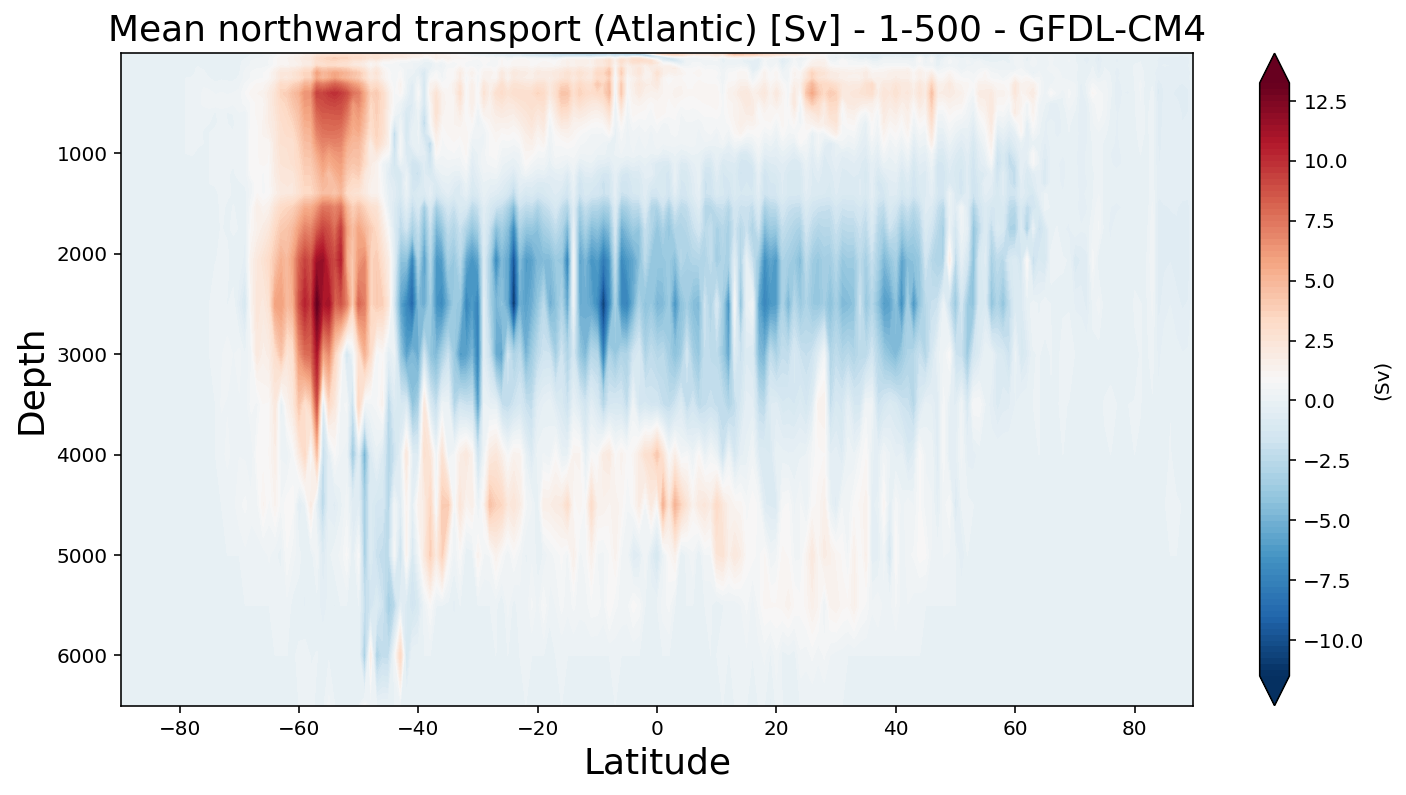

In [37]:
#plot #1, just transport
fig=plt.figure()
im=plt.contourf(Lat_regrid_1D, Depths, Transport_lon_final_mean, 100, cmap=plt.cm.RdBu_r, extend = 'both')
plt.gca().invert_yaxis()
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Depth', fontsize=18)
plt.title('Mean northward transport (Atlantic) [Sv] - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
cbar = plt.colorbar(im, extend='max')
cbar.set_label('(Sv)')
mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_Transport_lon_final_mean.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

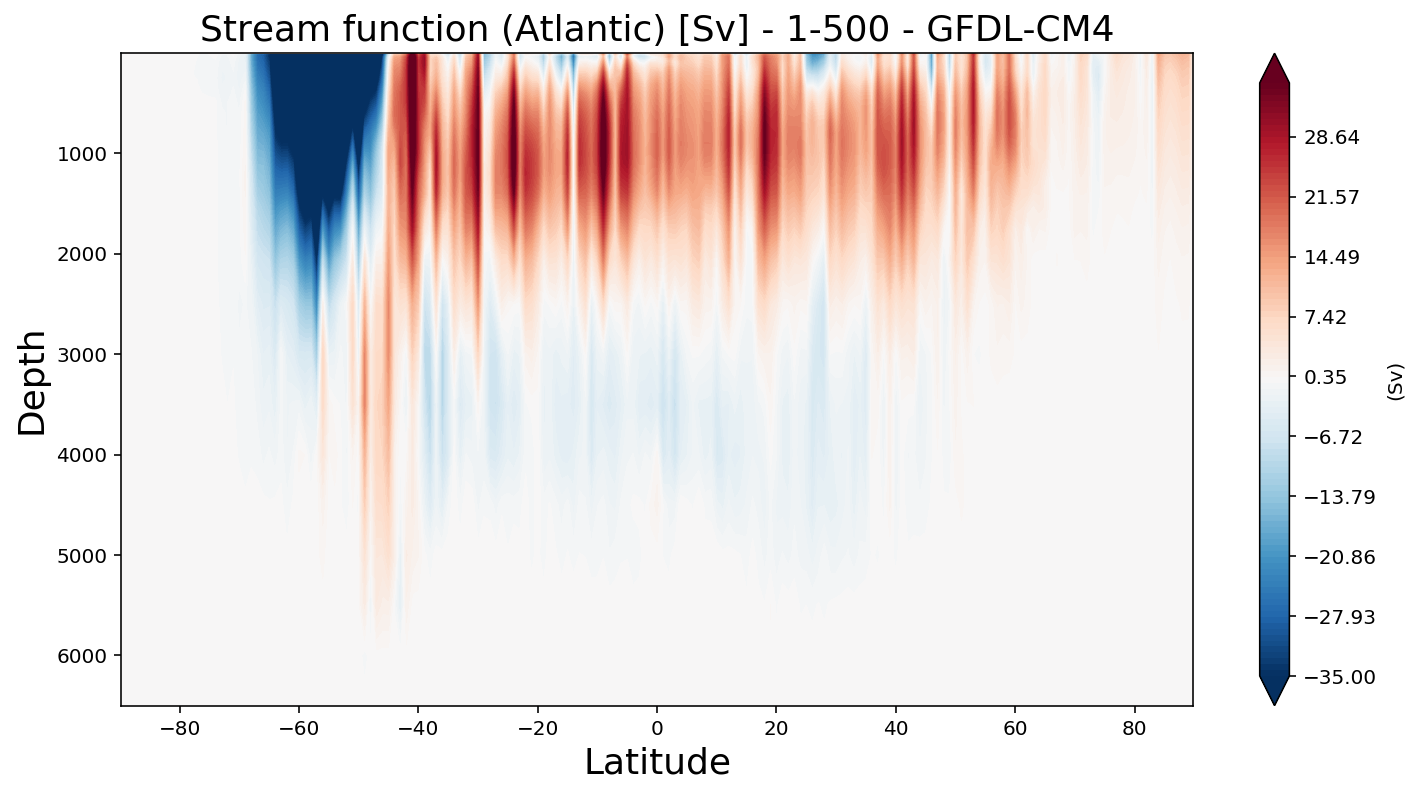

In [39]:
levels=np.linspace(-35,35,100) 
#plot #2, streamfunction
fig=plt.figure()
im=plt.contourf(Lat_regrid_1D, Depths, Stream_function_ave, levels, cmap=plt.cm.RdBu_r, extend = 'both')
plt.gca().invert_yaxis()
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Depth', fontsize=18)
plt.title('Stream function (Atlantic) [Sv] - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
cbar = plt.colorbar(im, extend='max')
cbar.set_label('(Sv)')
mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_Stream_function_ave.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

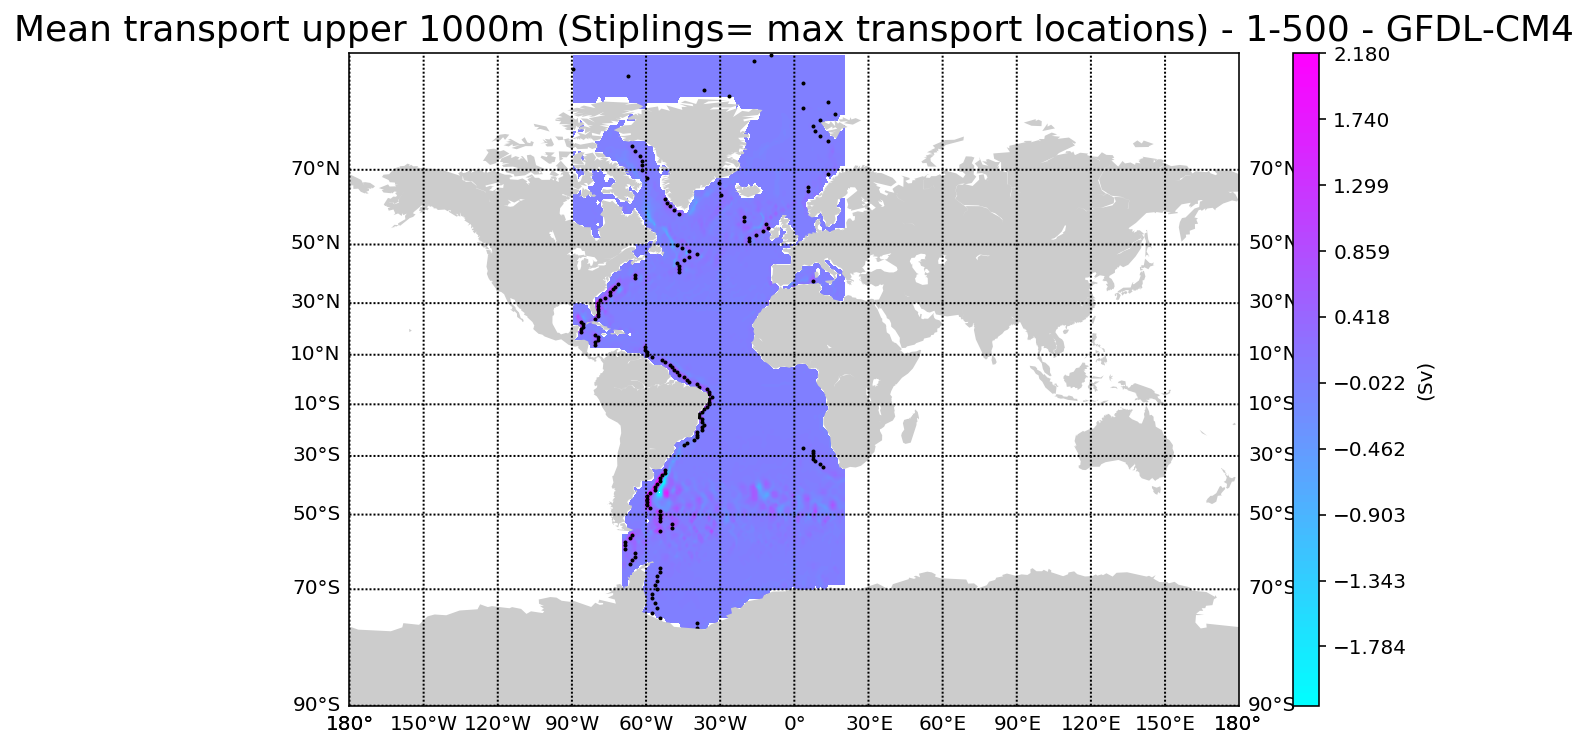

In [42]:
#plot #3, map of mean transport upper 1000m with indeces of max for each lat
fig=plt.figure()
m = Basemap( projection='mill',lon_0=0)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-90,90,20), labels=[1,1,0,1])
m.drawmeridians(np.arange(0,360,30), labels=[1,1,0,1])
bounds_max=float("{0:.02f}".format(np.nanpercentile(transport_0_1000_mean, 99.9))) # Upper bound of plotted values to be used for colorbar, which is 98th percentile of data, with 2 decimals
levels=np.linspace(-1*bounds_max,bounds_max,100)  
im=m.contourf(lon_stream,lat_stream,transport_0_1000_mean,levels,latlon=True, cmap=plt.cm.cool)
m.scatter(Lon_regrid_2D[ii_max,jj_max], Lat_regrid_2D[ii_max,jj_max],1,c='k',latlon=True)
cbar = m.colorbar(im,"right", size="3%", pad="6%", extend = 'both') # extend='both' will extend the colorbar in both sides (upper side and down side)
cbar.set_label('(Sv)')
plt.title('Mean transport upper 1000m (Stiplings= max transport locations) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_transport_0_1000_mean_stiple.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

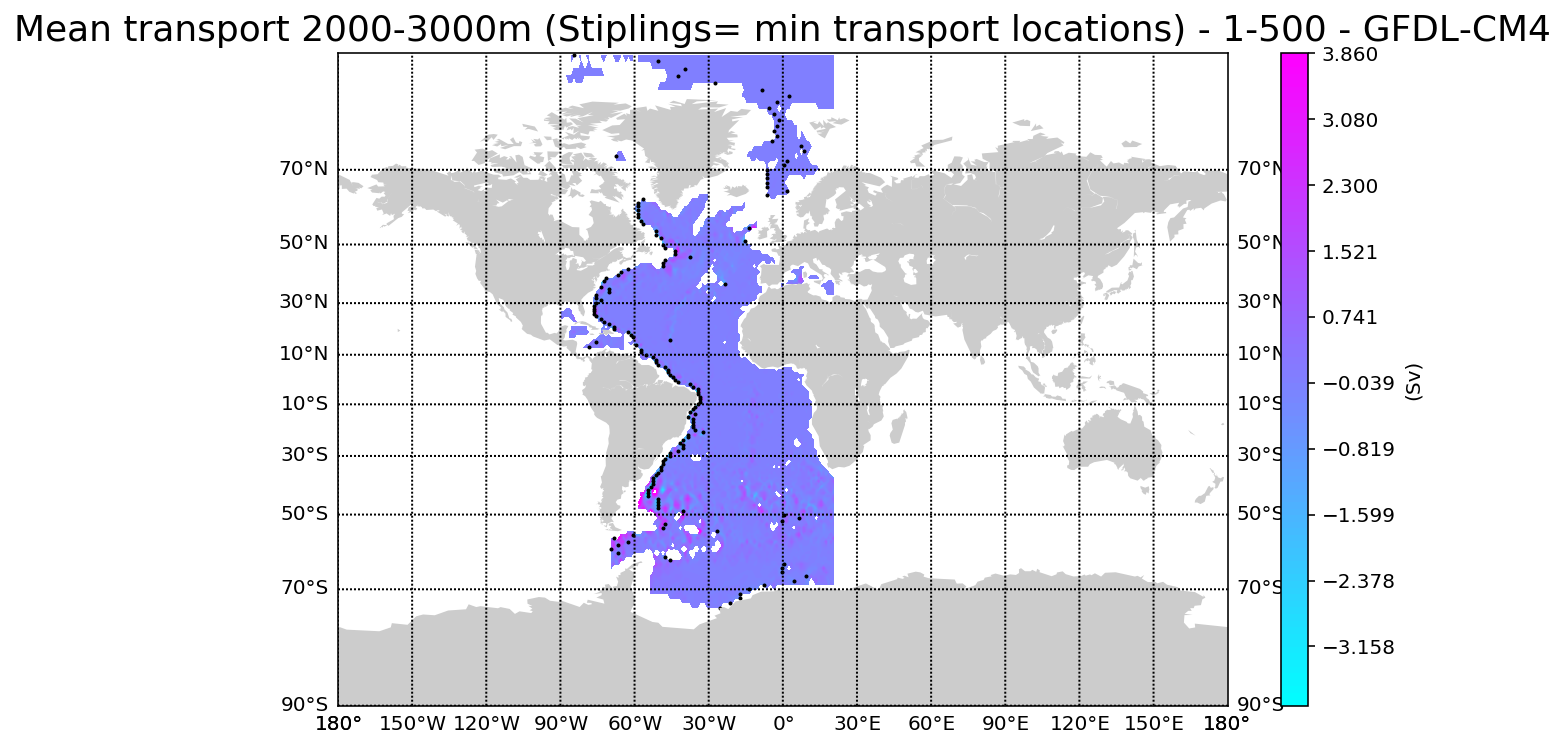

In [65]:
#plot #4, map of mean transport 2000m-3000m with indeces of max for each lat
fig=plt.figure()
m = Basemap( projection='mill',lon_0=0)
m.fillcontinents(color='0.8')
m.drawparallels(np.arange(-90,90,20), labels=[1,1,0,1])
m.drawmeridians(np.arange(0,360,30), labels=[1,1,0,1])
bounds_max=float("{0:.02f}".format(np.nanpercentile(transport_2000_3000_mean, 99.9))) # Upper bound of plotted values to be used for colorbar, which is 98th percentile of data, with 2 decimals
levels=np.linspace(-1*bounds_max,bounds_max,100)  
im=m.contourf(lon_stream,lat_stream,transport_2000_3000_mean,levels,latlon=True, cmap=plt.cm.cool)
m.scatter(Lon_regrid_2D[ii_min,jj_min], Lat_regrid_2D[ii_min,jj_min],1,c='k',latlon=True)
cbar = m.colorbar(im,"right", size="3%", pad="6%", extend = 'both') # extend='both' will extend the colorbar in both sides (upper side and down side)
cbar.set_label('(Sv)')
plt.title('Mean transport 2000-3000m (Stiplings= min transport locations) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
#mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_transport_2000_3000_mean_stiple.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [66]:
##############################################################################
#################        To restore:        ##################################
import os
import shelve

dir_pwd = os.getcwd() # Gets the current directory (and in which the code is placed)
filename_out = (dir_pwd + '/AllResults_'+GCM+'_500yr.out') # Directory to save processed data

my_shelf = shelve.open(filename_out)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [67]:
WS_index_rm = copy.deepcopy(WS_index)

#multiplying by -1 as we have convection when temperature is low(opposite to the index which we calculate)
WS_index_rm=runningMeanFast(WS_index_rm, 10)
WS_index_rm=WS_index_rm*(-1)

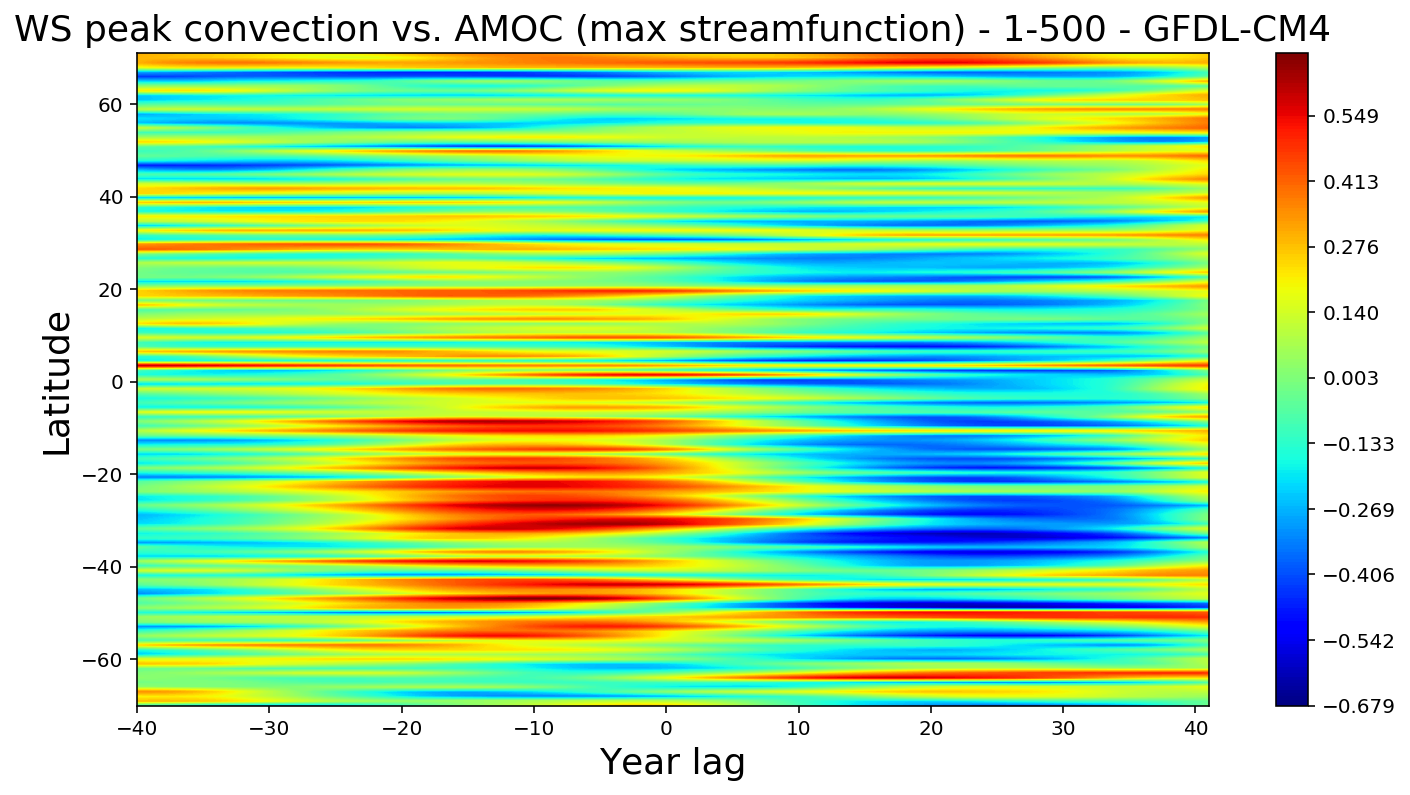

In [68]:
#### WS plots ####
lag_time=40

fig=plt.figure()
data=[]
for i in range(len(AMOC_max[0][20:161])):
    stream=runningMeanFast(AMOC_max[:,i+lag_time], 10)
    r=lag_cor_data(WS_index_rm,stream,lag_time)
    data.append(r)
data=np.asarray(data)
x=np.linspace(-lag_time,lag_time+1, 2*lag_time)
y=np.linspace(-70,70+1, 2*70+1)

x,y=np.meshgrid(x,y)
cmap_limit=np.nanmax(np.abs(data))
levels=np.linspace(-cmap_limit,cmap_limit,200)
im=plt.contourf(x,y,data,levels,latlon=True, cmap=plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('WS peak convection vs. AMOC (max streamfunction) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_lagcor_convec_AMOC_max_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

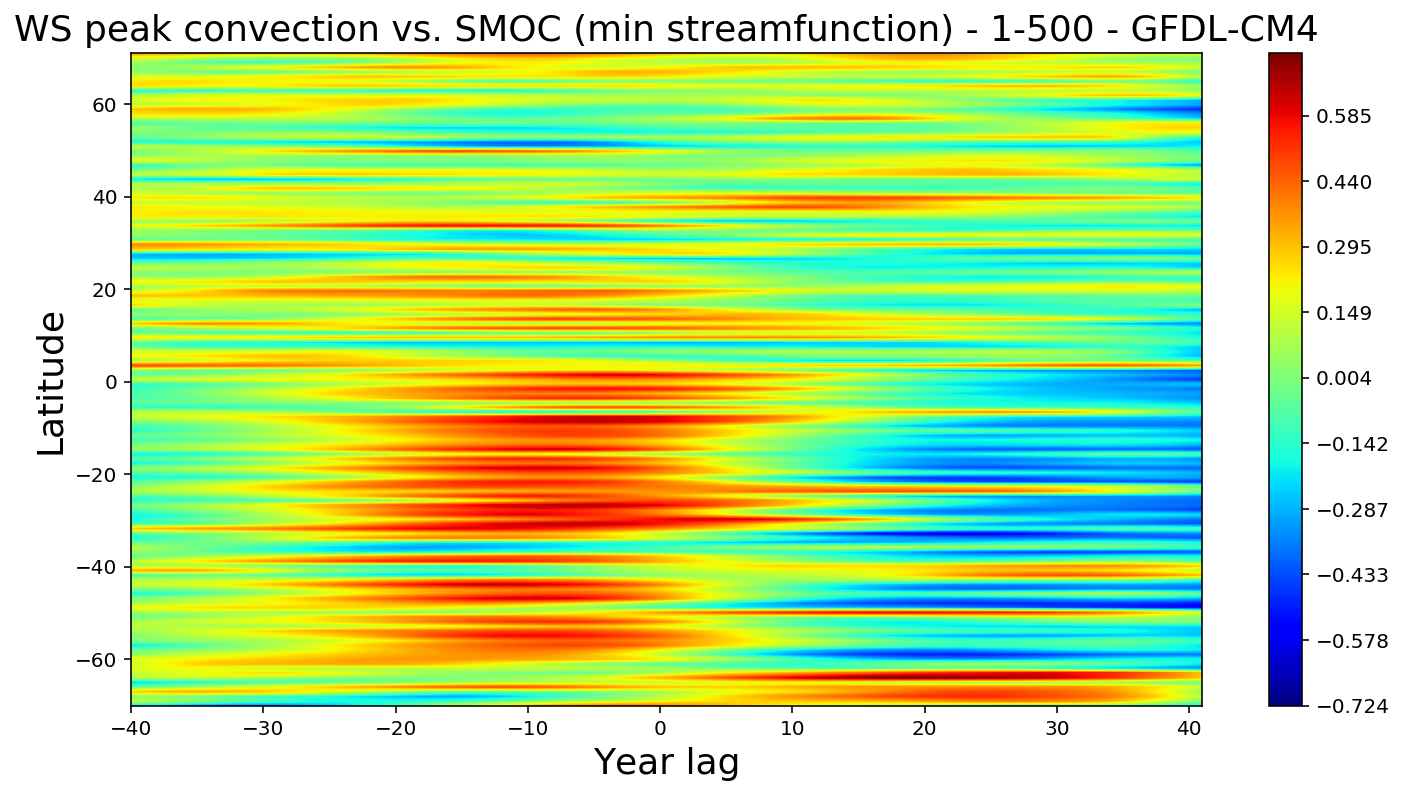

In [69]:
fig=plt.figure()
data=[]
for i in range(len(SMOC_min[0][20:161])):
    stream=runningMeanFast(SMOC_min[:,i+lag_time], 10)
    r=lag_cor_data(WS_index_rm,stream,lag_time)
    data.append(r)
data=np.asarray(data)
x=np.linspace(-lag_time,lag_time+1, 2*lag_time)
y=np.linspace(-70,70+1, 2*70+1)

x,y=np.meshgrid(x,y)
cmap_limit=np.nanmax(np.abs(data))
levels=np.linspace(-cmap_limit,cmap_limit,200)
im=plt.contourf(x,y,data,levels,latlon=True, cmap=plt.cm.jet)
cb = plt.colorbar(im)
plt.xlabel('Year lag', fontsize=18)
plt.ylabel('Latitude', fontsize=18)
plt.title('WS peak convection vs. SMOC (min streamfunction) - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_lagcor_convec_SMOC_min_WS.png', format='png', dpi=300, transparent=True, bbox_inches='tight')

In [70]:
#######################################################
#%%####   Lagged Corrolations and PSD plots    ########
#######################################################
AMOC_max_50S= AMOC_max[:,40] # AMOC at 50S # Max of streamfunction method
AMOC_max_50S_m=runningMeanFast(AMOC_max_50S, 10)
AMOC_max_30S= AMOC_max[:,60] # AMOC at 30S # Max of streamfunction method
AMOC_max_30S_m=runningMeanFast(AMOC_max_30S, 10)
AMOC_max_50N= AMOC_max[:,140] # AMOC at 50N # Max of streamfunction method
AMOC_max_50N_m=runningMeanFast(AMOC_max_50N, 10)
AMOC_max_30N= AMOC_max[:,120] # AMOC at 30N # Max of streamfunction method
AMOC_max_30N_m=runningMeanFast(AMOC_max_30N, 10)
AMOC_max_eq= AMOC_max[:,90] # AMOC at 30N # Max of streamfunction method
AMOC_max_eq_m=runningMeanFast(AMOC_max_eq, 10)

SMOC_min_50S= SMOC_min[:,40] # SMOC at 50S # Max of streamfunction method
SMOC_min_50S_m=runningMeanFast(SMOC_min_50S, 10)
SMOC_min_30S= SMOC_min[:,60] # SMOC at 30S # Max of streamfunction method
SMOC_min_30S_m=runningMeanFast(SMOC_min_30S, 10)
SMOC_min_50N= SMOC_min[:,140] # SMOC at 50N # Max of streamfunction method
SMOC_min_50N_m=runningMeanFast(SMOC_min_50N, 10)
SMOC_min_30N= SMOC_min[:,120] # SMOC at 30N # Max of streamfunction method
SMOC_min_30N_m=runningMeanFast(SMOC_min_30N, 10)
SMOC_min_eq= SMOC_min[:,90] # SMOC at 30N # Max of streamfunction method
SMOC_min_eq_m=runningMeanFast(SMOC_min_eq, 10)


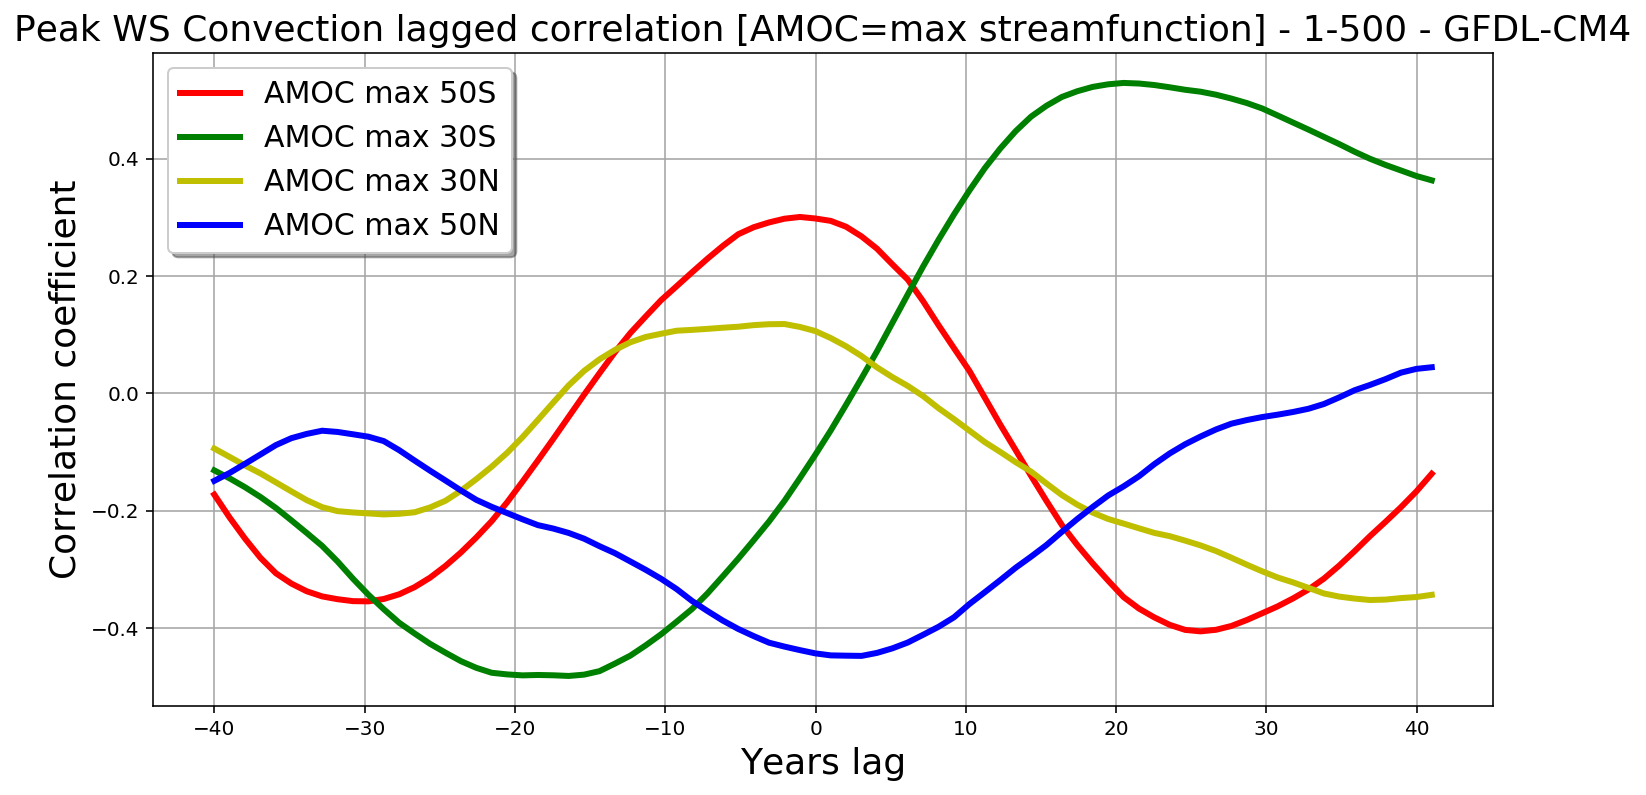

distributed.scheduler - INFO - Remove worker tcp://10.32.12.32:42487
distributed.core - INFO - Removing comms to tcp://10.32.12.32:42487
distributed.scheduler - INFO - Lost all workers
distributed.scheduler - INFO - Register tcp://10.32.12.2:41743
distributed.scheduler - INFO - Starting worker compute stream, tcp://10.32.12.2:41743
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Remove worker tcp://10.32.12.2:41743
distributed.core - INFO - Removing comms to tcp://10.32.12.2:41743
distributed.scheduler - INFO - Lost all workers


In [71]:
####################################################################
### AMOC/SMOC Lagged Corrolation Plots - Max/Min Stream function ###

fig=plt.figure()
#lag_cor(WS_index_rm[:-9],ENSO_m[:-9],40,'m','ENSO index')
#lag_cor(WS_index_rm[:-9],NAO_m[:-9],40,'c','NAO index')
lag_cor(WS_index_rm[:-9],AMOC_max_50S_m[:-9],40,'r','AMOC max 50S')
lag_cor(WS_index_rm[:-9],AMOC_max_30S_m[:-9],40,'g','AMOC max 30S')
lag_cor(WS_index_rm[:-9],AMOC_max_30N_m[:-9],40,'y','AMOC max 30N')
lag_cor(WS_index_rm[:-9],AMOC_max_50N_m[:-9],40,'b','AMOC max 50N')
plt.legend()
plt.title('Peak WS Convection lagged correlation [AMOC=max streamfunction] - '+str(year_start)+'-'+str(year_end)+' - '+str(GCM), fontsize=18)
plt.xlabel('Years lag', fontsize=18)
plt.ylabel('Correlation coefficient', fontsize=18)    
plt.legend(shadow=True, prop={'size': 15})
mng = plt.get_current_fig_manager()
fig.savefig(dir_figs+str(GCM)+'_lagcor_WSconvection_AMOC_max_1.png', format='png', dpi=300, transparent=True, bbox_inches='tight')